# Automated Workflow for ML Models

First approach for an automated workflow consisting in data splitting, preprocessing, training, hyperparameter tuning and testing <b> specifically for ML models generated with keras </b>. Since no automated pipelines exist (or at least I could not find one) for using keras ML models for time-series forecasting that can be specified according to our requirements, most of the functions used are customized. <br>

<b>Already implemented:</b>
* Data splitting (Train-Val / Test) according to specified split date
* Conversion to supervised learning problem for ML models
* Rolling Window Forward Validation splitting ("Schnaubelt, Matthias. A comparison of machine learning model validation schemes for non-stationary time series data")
* Grid search for hyperparameter tuning and selection of best model according to minimum RMSE
* Retraining of final model on entire dataset and evaluating accuracy using RMSE, MSE, MAPE
* First test for 1-hour ahead forecasts and 3 tuneable hyperparameters to check basic functionality and plausibility of results

<b>To do:</b>
* Integrate with "live" data
* Include additional data sources
* Generate plots for hyperparameter optimization and final testing
* Include additional performance metrics: sMAPE to resolve issues with MAPE, perhaps some scaled metrics
* Include additional evaluation methods: Diebold-Mariano tests and/or residual diagnostics, efficiency (total number of FLOPs)
* Consider execution time of hyperparameter optimization (perhaps decrease number of folds)
* Test with all tunable hyperparameters
* Tests for 1-day and 1-week ahead forecasts
* Test/integrate with other ML models (RNN, LSTM, GRU, SVR, hybrid models, ...)

<b>Requirements:</b>
pandas,
numpy,
matplotlib,
sklearn,
math,
keras

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MaxAbsScaler

from math import sqrt

sns.set_style('whitegrid')

## Read Data

In [ ]:
# Read data from csv (for development purposes, TO DO: integrate with montel data + external data)
data = pd.read_csv('data.csv')
X = data.Time
Y = data.Value

# Get information on min/max dates and number of datapoints 
datapoints = X.index.max()+1
date_min = X.min()
date_max = X.max()

print('Number of datapoints in the Dataset: {}'.format(datapoints))
print('Minimum date from data set: {}'.format(date_min))
print('Maximum date from data set: {}'.format(date_max))

In [ ]:
data.head()

In [ ]:
data.describe()

## Generate Hourly, Daily, Weekly Data for Prediction

In [ ]:
# Generate dataframe with datetime index
data_hourly = data.set_index('Time')
data_hourly.index = pd.date_range(date_min,date_max,freq='H')

# Resample dataframes for testing of different temporal resolutions
data_daily = data_hourly.resample('1D').mean()
data_weekly = data_hourly.resample('1W').mean()
data_monthly = data_hourly.resample('1M').mean()

## Plot Data

In [ ]:
ax = data_daily.plot(linewidth=0.1, figsize=(20,5))
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

## Preprocessing and Data Splitting

In [ ]:
def train_val_test_split(df_datetime, split_date):
    '''
    Splits dataframe into a training/validation set and a test set according to a specified split date.
    df_datetime: pandas.core.frame.DataFrame
    split_date: str in the format 'YYYY-MM-DD hh:mm:ss'
    
    '''
    df_train_val = df_datetime.loc[df_datetime.index < split_date]
    df_test = df_datetime.loc[df_datetime.index >= split_date]
    return df_train_val, df_test

In [ ]:
SPLIT_DATE = '2019-06-01 00:00:00'

df_train_val, df_test = train_val_test_split(data_hourly, SPLIT_DATE)

In [ ]:
df_train_val.tail()

In [ ]:
df_test.head()

## Rolling Window Forward Validation Split for Hyperparameter Optimization

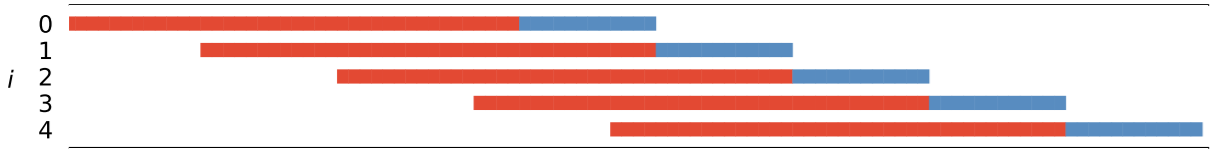

In [ ]:
def convert2matrix(data_arr, look_back, gap):
    '''
    Converts value array into features (X) and response (Y) to create a supervised learning problem needed for ML mdoels.
    data_arr: numpy.ndarray, shape: (#timesteps,) 
    look_back: int, determines how many timesteps are used for making a prediction (#features per sample)
    gap: int, determines how far into the future predictions are made (one hour: gap=0, 1 day: gap=23, 1 week: gap=167)
    '''
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d])
        Y.append(data_arr[d+gap])
    return np.array(X), np.array(Y)

In [ ]:
def create_folds(num_folds, quot_train, X_train_val, Y_train_val):
    '''
    Creates folds for rolling window forward validation according to "Schnaubelt, Matthias. A comparison of machine learning model validation schemes for non-stationary time series data".
    num_folds: int, specifies number of folds used for validation
    quot_train: float, specifies the percentage of training data in each fold
    X_train_val: numpy.ndarray, shape: (#timesteps, look_back)
    Y_train_val: numpy.ndarray, shape: (#timesteps,)
    '''
    ratio = int(quot_train/(1-quot_train))

    len_val = int(np.shape(X_train_val)[0]/(num_folds+ratio))
    len_train = int(np.shape(X_train_val)[0]-num_folds*len_val)
    len_fold = len_train + len_val

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for i in range(num_folds):
        X_train.append(X_train_val[i*len_val:i*len_val+len_train]) 
        Y_train.append(Y_train_val[i*len_val:i*len_val+len_train])
        X_val.append(X_train_val[i*len_val+len_train:i*len_val+len_fold])
        Y_val.append(Y_train_val[i*len_val+len_train:i*len_val+len_fold])
        
    return X_train, Y_train, X_val, Y_val

In [ ]:
# Convert data to numpy arrays for keras DNN
data_train_val = df_train_val.to_numpy()[:,0]
data_test = df_test.to_numpy()[:,0]

# Setup look_back window and gap in forecast horzion
look_back = 30
gap = 0 # one-hour ahead forecast: gap = 0, 1 day ahead forecast: gap = 23, 1 week ahead forecast: gap = 167

# Transform to supervised learning problem for compatibility with keras ML models
X_train_val, Y_train_val = convert2matrix(data_train_val, look_back, gap)
X_test, Y_test = convert2matrix(data_test, look_back, gap)

# Create multiple folds of train and validation data splits for rolling window forward validation (see paper 5)
num_folds = 5
quot_train = 0.8

X_train, Y_train, X_val, Y_val = create_folds(num_folds, quot_train, X_train_val, Y_train_val)

## Hyperparameter Optimization

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid
from keras.activations import relu, elu
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
#from keras_flops import get_flops

# Initialize early stopping to combat overfitting
early_stopping = EarlyStopping(monitor='loss', patience=10)

In [ ]:
def smape(y_true, y_pred):
    '''
    Calculates customized metric sMAPE as improvement of the classic MAPE.
    TO DO: integrate in keras model API
    '''
    return np.mean(200*abs(y_true-y_pred)/(y_true+y_pred))

In [ ]:
def model_dnn(params, metrics, look_back):
    '''
    Initializes a keras DNN with two hidden layers.
    params: <class 'dict'>, combination of hyperparameters from specified parameter grid
    metrics: list, implemented so far are RMSE, MAE, MAPE
    look_back: int, necessary for dimension of input neuron
    '''
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=look_back,
                    activation=params['activation']))
    model.add(Dense(params['second_neuron'],
                    activation=params['activation']))
    model.add(Dropout(params['dropout']))

    model.add(Dense(1))
    
    model.compile(loss='mse', metrics=metrics)
    return model

In [ ]:
def rolling_window_forward_validation_score(model, params, X_train, Y_train, X_val, Y_val):
    '''
    Calculates the metrics specified in the model initialization (currently RMSE, MAE, MAPE) for each fold.
    Returns the means of the specified metrics over all folds. 
    
    model: keras.engine.sequential.Sequential
    params: <class 'dict'>, combination of hyperparameters from specified parameter grid
    X_train: list, shape: (num_folds, len_train, look_back)
    Y_train: list, shape: (num_folds, len_train)
    X_val: list, shape: (num_folds, len_val, look_back)
    Y_val: list, shape: (num_folds, len_val)
    '''
    max_abs_scaler = MaxAbsScaler()
    cv_scores = []
    for i in range(num_folds):
        X_train_prepro = max_abs_scaler.fit_transform(X_train[i])
        X_val_prepro = max_abs_scaler.transform(X_val[i])
        history = model.fit(X_train_prepro, Y_train[i], epochs=params['epochs'], verbose=1, callbacks=[early_stopping], shuffle = False)
        score = model.evaluate(X_val_prepro, Y_val[i], verbose=0)
        #print(score)
        cv_scores.append(score)
        #print(cv_scores)
    return np.mean(cv_scores,0)[1:]

In [ ]:
def get_min_rmse_results(rwfv_scores, param_configs):
    '''
    Determines the configuration yielding the minimum RMSE. 
    Returns index of minimum RMSE, value of minimum RMSE and the corresponding parameter configuration.
    
    rwfv_scores: list
    param_configs: list
    '''
    val_min = float("inf")
    
    for i in range(len(rwfv_scores)):
        if rwfv_scores[i][1] < val_min:
            ind_min_rmse = i
            val_min = rwfv_scores[i][1]
            
    best_config = param_configs[ind_min_rmse]
    return ind_min_rmse, val_min, best_config

In [ ]:
def grid_search_rwfv(grid, metrics, look_back, X_train, Y_train, X_val, Y_val):
    '''
    Performs a grid search over all possible parameter configurations. 
    Evaluates each configuration using rolling window forward validation. 
    Returns the optimum parameter configuration, the index yielding minimum RMSE and the minimum RMSE value itself. 
    
    grid: list, contains all tunable hyperparameters and corresponding values
    metrics: list, implemented so far are RMSE, MAE, MAPE
    X_train: list, shape: (num_folds, len_train, look_back)
    Y_train: list, shape: (num_folds, len_train)
    X_val: list, shape: (num_folds, len_val, look_back)
    Y_val: list, shape: (num_folds, len_val)
    '''
    rwfv_scores = []
    param_configs = []

    # iterate over parameters from grid and calculate RMSE/MAE/MAPE
    for params in grid:
        # Fit Model
        model = model_dnn(params, metrics, look_back)
        # Estimate error with rolling window forward validation
        rwfv_score = rolling_window_forward_validation_score(model, params, X_train, Y_train, X_val, Y_val)
        rwfv_scores.append(rwfv_score)
        param_configs.append(params)
        #print(rwfv_scores)
        #print(param_configs)

    # select best hyperparameter config based on minimum rmse
    ind_min_rmse, min_rmse, best_config = get_min_rmse_results(rwfv_scores, param_configs)

    return best_config, ind_min_rmse, min_rmse

In [ ]:
# Define parameters to be optimized in hyperparameter grid
param_grid = [{#'lr': (0.5, 5, 10),
     'first_neuron':[4, 8, 16, 32, 64, 128],
     'second_neuron':[4, 8, 16, 32, 64, 128],
     #'hidden_layers':[0, 1, 2],
     #'batch_size': [2, 10, 30],
     'epochs': [10, 25, 50, 100], 
     'dropout': [0, 0.1, 0.25, 0.5, 0.75, 1],
     #'kernel_initializer': ['uniform','normal'],
     #'optimizer': ['Nadam', 'Adam'],
     #'losses': ['mean_squared_error', 'binary_crossentropy'],
     'activation':['relu', 'elu', 'tanh', 'softmax']}]

# Grid for testing the workflow with reduced number of options
test_grid = [{'first_neuron':[4, 32],
     'second_neuron':[4, 32],
     'epochs': [10], 
     'dropout': [0, 0.5],
     'activation':['relu', 'elu']}]

#grid = list(ParameterGrid(param_grid))
grid = list(ParameterGrid(test_grid))

metrics = [RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()]

best_config, ind_min_rmse, min_rmse = grid_search_rwfv(grid, metrics, look_back, X_train, Y_train, X_val, Y_val)

print("Minimum RMSE: ", "%.2f" % min_rmse)
print("Parameter configuration yielding minimum RMSE: ", best_config)

## Retrain Model on Entire Training/Validation Dataset and Evaluate on Test Set

In [ ]:
# Specify evaulation metrics
metrics_test = [RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()]

# Initialize model with optimal config
best_model = model_dnn(best_config, metrics_test, look_back)

# Apply appropriate scaling
max_abs_scaler = MaxAbsScaler()
X_train_val_prepro = max_abs_scaler.fit_transform(X_train_val)
X_test_prepro = max_abs_scaler.transform(X_test)

# Fit model on entire training/validation dataset
history = best_model.fit(X_train_val_prepro, Y_train_val, epochs=best_config['epochs'], verbose=1, callbacks=[early_stopping], shuffle = False)

In [ ]:
# Evaluate final model on the held-out test set
final_score = best_model.evaluate(X_test_prepro, Y_test, verbose=0)[1:]
print("Final RMSE:", "%.2f" % final_score[0])
print("Final MAE:", "%.2f" % final_score[1])
print("Final MAPE:", "%.2f" % final_score[2])

## TO DO: Diebold-Mariano-Tests

## TO DO: Residual Diagnostics

## TO DO: Efficiency (Total Number of FLOPs)
Implement FLOP count, e.g. with keras-flops get_flops
https://pypi.org/project/keras-flops/